# Get path

Get path of drop from data file

In [1]:
using Optim
using BenchmarkTools
using JLD2
using Plots

Imputs needed:

- Number of gridpoints
- ~Extents~ Got through grid
    

In [348]:
Ny,Nz = 64, 64

(64, 64)

In [349]:
filename = "./drop_r2_mu1e1.jld2"
file = jldopen(filename);

In [350]:
Ly = file["grid/Ly"]
Lz = file["grid/Lz"]

2.0

In [351]:
yb = range(-Ly/2,Ly/2,length=Ny)
zb = range(-Lz,0,length=Nz)

-2.0:0.031746031746031744:0.0

In [358]:
#using Printf
#file = jldopen(filename)
iterations = parse.(Int, keys(file["timeseries/t"]));
# Plot buoyancy

@gif for iter in iterations
    # retrieve solution from JLD2 file

    t = file["timeseries/t/$iter"]*7.4e-2
    b_snapshot = file["timeseries/b/$iter"][1, :, :]
    #b_snapshot = file["timeseries/v/$iter"][1, 1:64, 1:64]
    #b_snapshot = file["timeseries/w/$iter"][1, 1:64, 1:64]
    #b_snapshot = file["timeseries/ω/$iter"][1, 1:64, 1:64]
    #b_snapshot = file["timeseries/s/$iter"][1, 1:64, 1:64]

    contourf(yb, zb, b_snapshot',color=:balance, 
             #clim=(0.0,0.001),
             title="Vertical velocity, t=$(@sprintf("%.2f", t)) ms",
             aspect_ratio=:equal) 
end

Animation("/var/folders/pb/__2_zr2s5c7brz7s8bvg4x580000gn/T/jl_8dmQpd", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000093.png", "000094.png", "000095.png", "000096.png", "000097.png", "000098.png", "000099.png", "000100.png", "000101.png", "000102.png"])

In [360]:
#gif(anim, "anim_r2_mu1e1_b_version2.gif", fps = 15)

### Test making into bitmap

┌ Info: Saved animation to 
│   fn = /Users/williamdavis/Dropbox/viscosometry/code/tmp.gif
└ @ Plots /Users/williamdavis/.julia/packages/Plots/w4QRq/src/animation.jl:104


Plots.AnimatedGif("/Users/williamdavis/Dropbox/viscosometry/code/tmp.gif")
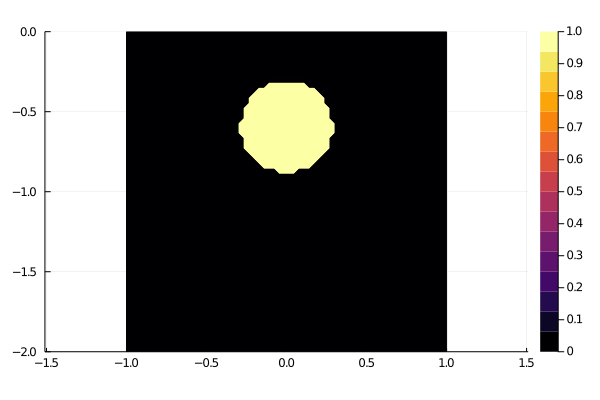

In [314]:
threshold(x) = x < -0.05
@gif for iter in iterations
    # retrieve solution from JLD2 file

    b_snapshot = threshold.(file["timeseries/b/$iter"][1, :, :])
    
    contourf(yb, zb, b_snapshot',color=:inferno, 
             #clim=(0.0,0.001),
             aspect_ratio=:equal) 
end

In [317]:
iterations'[10]

2251

A single image

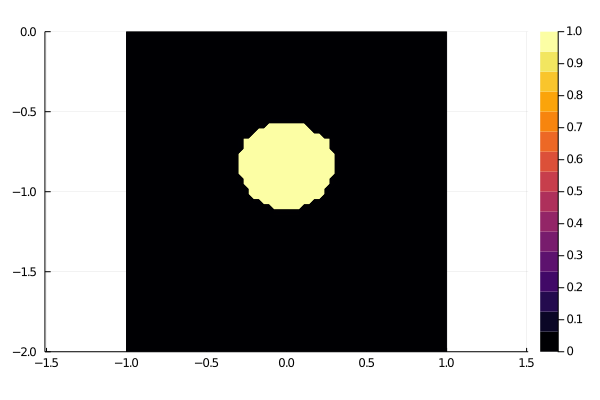

In [319]:
b_snapshot = threshold.(file["timeseries/b/2251"][1, :, :])
contourf(yb, zb, b_snapshot',color=:inferno, 
             #clim=(0.0,0.001),
             aspect_ratio=:equal) 

In [320]:
# Circle function
circ_guess(y,z,r,y₀,z₀) = (r>sqrt((y-y₀)^2 + (z-z₀)^2))

circ_guess (generic function with 1 method)

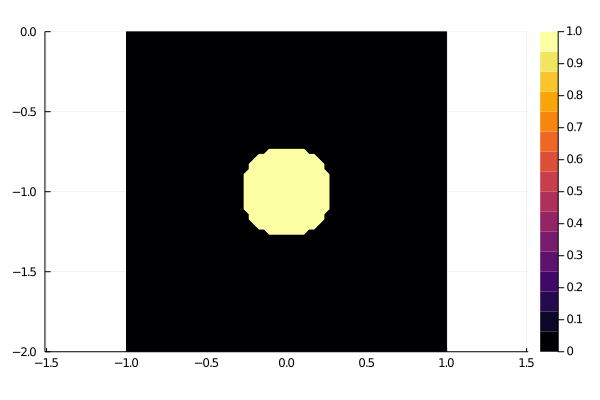

In [321]:
circ_guess1(y, z) = circ_guess(y,z,0.3,0,-1)

contourf(yb, zb, circ_guess1.(yb, zb')',color=:inferno, 
             #clim=(0.0,0.001),
             aspect_ratio=:equal) 

In [322]:
# Misfit
function plot_error(data, yb, zb, r, y₀, z₀)
    
    circ_guess_in(y,z) = circ_guess(y,z,r,y₀,z₀)
    
    circ_guess_data = circ_guess_in.(yb, zb')
end
const guess_cache = circ_guess.(yb,zb',0,0,0)
function circ_error(data, circ_guess_data, yb, zb, r, y₀, z₀)
    
    circ_guess_in(y,z) = circ_guess(y,z,r,y₀,z₀)
    
    for (i, yy) in enumerate(yb), (j, zz) in enumerate(zb)
        circ_guess_data[i,j] = circ_guess_in(yy, zz)
        circ_guess_data[i,j] ⊻= data[i,j]
    end
    #circ_guess_data .= circ_guess_in.(yb, zb')
    
    #circ_guess_data -= data
    
    #circ_guess_data = abs.(circ_guess_data)
    
    
    return reduce(+, circ_guess_data)
end

circ_error (generic function with 1 method)

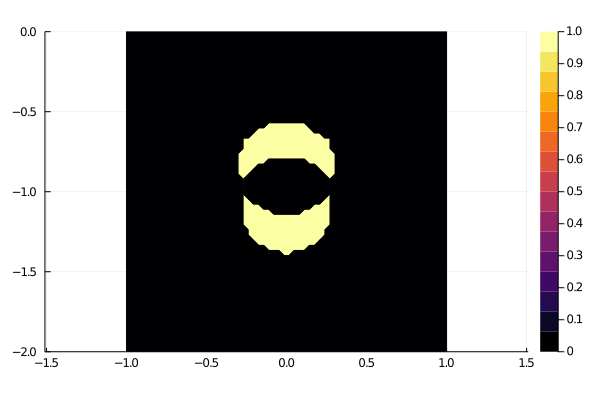

In [323]:
contourf(yb, zb, abs.(plot_error(b_snapshot, yb, zb, 0.3,0,-1.1)' - b_snapshot'),color=:inferno, 
             #clim=(0.0,0.001),
             aspect_ratio=:equal) 

In [324]:
circ_error(b_snapshot, guess_cache, yb, zb, 0.3,0,-1)

197

In [331]:
circ_error(b_snapshot, guess_cache, yb, zb, 0.3,0,-0.8)

55

In [327]:
struct ParameterGrid2D
    r_range::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}
    y₀_range::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}
    z₀_range::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}
end

In [328]:
const gridCoarse = ParameterGrid2D(0.0:0.1:1.0, -0.5:0.1:0.5, -6:0.1:0);

In [329]:
const b_test = copy(b_snapshot)
const yb_test = copy(yb)
const zb_test = copy(zb)
function grid_search(pgrid::ParameterGrid2D, bitmap_input)
    i_loc, j_loc, k_loc = 1, 1, 1
    
    val_min = circ_error(bitmap_input, guess_cache, yb_test, zb_test, 
            pgrid.r_range[1], pgrid.y₀_range[1], pgrid.z₀_range[1])
    for (i, r) in enumerate(pgrid.r_range)
        for (j, y) in enumerate(pgrid.y₀_range)
            for (k, z) in enumerate(pgrid.z₀_range)
                err = circ_error(bitmap_input, guess_cache, yb_test, zb_test, r, y, z)
                if err < val_min
                    val_min = err
                    i_loc, j_loc, k_loc = i, j, k
                end
            end
        end
    end
    return (i_loc, j_loc, k_loc), val_min
end

grid_search (generic function with 1 method)

In [330]:
tmp2 = grid_search(gridCoarse,b_test)
println(tmp2)
println("r = ", gridCoarse.r_range[tmp2[1][1]])
println("y = ", gridCoarse.y₀_range[tmp2[1][2]])
println("z = ", gridCoarse.z₀_range[tmp2[1][3]])

((4, 6, 53), 55)
r = 0.3
y = 0.0
z = -0.8


In [332]:
to_minim(x) = circ_error(b_test, guess_cache, yb_test, zb_test, x[1], x[2], x[3])

to_minim (generic function with 1 method)

In [334]:
to_minim([0.3, 0.0, -0.8])

55

### Using Optim.jl

In [336]:
x0 = [0.3, 0.0, -0.8]
res = optimize(to_minim, x0)
res.minimizer

3-element Array{Float64,1}:
  0.2994664577033878
  0.010860298402147243
 -0.8319706972193538

In [337]:
to_minim(res.minimizer)

19

### Course then fine search

In [338]:
const Ncourse = 21
const gridCoarse = ParameterGrid2D(range(0,Ly/2,length=Ncourse), 
                                   range(-Ly/2,Ly/2,length=Ncourse), 
                                   range(-Lz,0,length=Ncourse))
function coarse_fine_search(pgrid::ParameterGrid2D, bitmap_input, guess_cache, ynodes, znodes)
    # Coarse search
    res_course = grid_search(pgrid,bitmap_input)
    
    # Fine search
    to_minim(x) = circ_error(bitmap_input, guess_cache, ynodes, znodes, x[1], x[2], x[3])
    x0 = [pgrid.r_range[res_course[1][1]],
          pgrid.y₀_range[res_course[1][2]],
          pgrid.z₀_range[res_course[1][3]]]
    res = optimize(to_minim, x0)
    
    return res.minimizer, res.minimum, x0
end

coarse_fine_search (generic function with 1 method)

In [339]:
coarse_fine_search(gridCoarse, b_test, guess_cache, yb_test, zb_test)

([0.2994664577033878, 0.010860298402147243, -0.8319706972193538], 19.0, [0.3, 0.0, -0.8])

In [340]:
#@btime coarse_fine_search(gridCoarse, b_test, guess_cache, yb_test, zb_test)

### For all times

In [341]:
Nt = length(iterations)
const t_vec = zeros(Nt)
const r_vec = zeros(Nt)
const y_vec = zeros(Nt)
const z_vec = zeros(Nt)
const ∂z∂t_vec = zeros(Nt-1)
const e_vec = zeros(Nt)
for (i, iter) in enumerate(iterations)
    # retrieve solution from JLD2 file

    b_bitmap = threshold.(file["timeseries/b/$iter"][1, :, :])
    res = coarse_fine_search(gridCoarse, b_bitmap, guess_cache, yb_test, zb_test)
    
    r_vec[i] = res[1][1]
    y_vec[i] = res[1][2]
    z_vec[i] = res[1][3]
    e_vec[i] = res[2]
    
    t = file["timeseries/t/$iter"]
    t_vec[i] = t
end

In [342]:
for i in 1:length(iterations)-1
    ∂z∂t_vec[i] = -(z_vec[i+1] - z_vec[i])/1
end

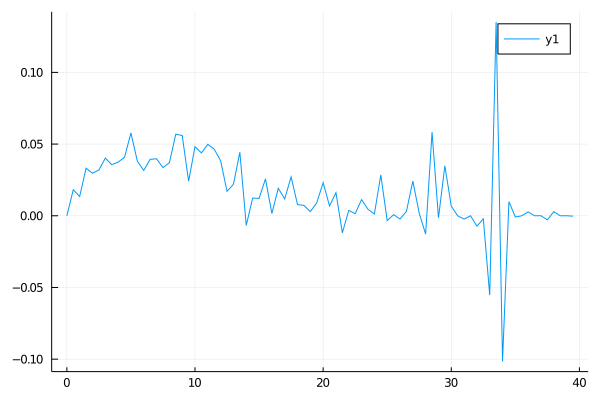

In [343]:
plot(t_vec[1:end-1], ∂z∂t_vec)

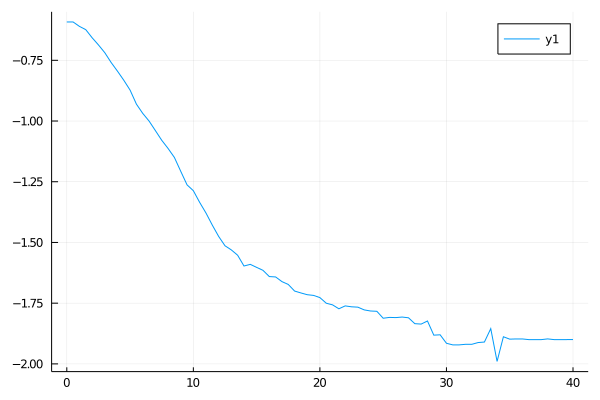

In [344]:
plot(t_vec, z_vec)

### Save txt file to be processed in matlab

In [345]:
using DelimitedFiles

In [346]:
txt_filename = filename[1:end-4] * "txt"

"./drop_r3_mu1e2.txt"

In [347]:
open(txt_filename, "w") do io
    writedlm(io, [t_vec r_vec y_vec z_vec e_vec])
end